# <p align="center">CNN-CT-BRAIN 🧠</p>

### 1. Empezamos importando librerias y configurando la semilla

In [54]:
import os as os
import numpy as np
import tensorflow as tf
import random

# Si usaramos GPU forma de saber su nombre
# tf.test.gpu_device_name()

# Declaramos la semilla
seed = 2027

# Semilla aleatoria en NumPy, TensorFlow y Python
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

class_folder_names = os.listdir("archive/files/")
class_folder_names # Clasificacion de los directorios


['aneurysm', 'cancer', 'tumor']

Como podemos ver estos son los nombres de los directorios que disponemos

### 2. Empezamos con la parte carga de datos y de preprocesamiento

In [42]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(base_dir):
    image_paths = []
    classes = []

    # Recorrer cada clase en el directorio base
    for cls in os.listdir(base_dir):
        class_path = os.path.join(base_dir, cls)

        # Verificar si es un directorio
        if os.path.isdir(class_path):
            # Recorrer cada archivo en el directorio de la clase
            for file_name in os.listdir(class_path):
                # Filtrar archivos con extensión 'jpg'
                if file_name.split('.')[-1] == 'jpg':
                    image_paths.append(os.path.join(class_path, file_name))
                    classes.append(cls)

    # Codificación de etiquetas
    le = LabelEncoder()
    y = le.fit_transform(classes)
    y = np.array(y)

    inputs = []

    # Cargar imágenes y convertirlas a arrays
    for i in tqdm(image_paths):
        image = load_img(i)
        img_array = img_to_array(image)
        inputs.append(img_array)

    X = np.array(inputs)

    return X, y

# Cargar y preprocesar imágenes
base_dir = "archive/files/"
X, y = load_and_preprocess_images(base_dir)

# Dividir los datos en conjuntos de entrenamiento y prueba
test_size = 0.2
num_classes = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Convertir etiquetas a su forma one-hot
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Preprocesar los datos (escalarlos entre 0 y 1 y convertir las etiquetas a one-hot encoding)
x_train = X_train.astype('float32') 
x_test = X_test.astype('float32') 

# Imprimir dimensiones de los conjuntos de entrenamiento y prueba
print(f"Train data shape: {x_train.shape}, y_train shape: {y_train_one_hot.shape}")
print(f"Test data shape: {x_test.shape}, y_test shape: {y_test_one_hot.shape}")

100%|██████████| 259/259 [00:15<00:00, 16.89it/s]


Train data shape: (207, 512, 512, 3), y_train shape: (207, 3)
Test data shape: (52, 512, 512, 3), y_test shape: (52, 3)


Como podemos observar tenemos 52 imágenes de prueba con las mismas dimensiones que las de entrenamiento.

### 3. Seguimos con la parte de visualizaccion de los datos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


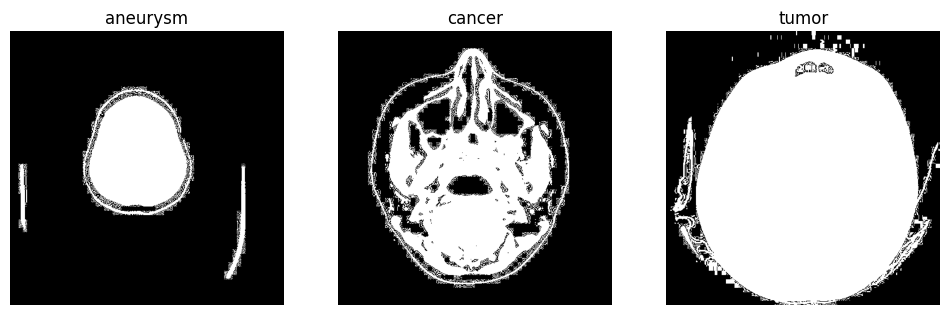

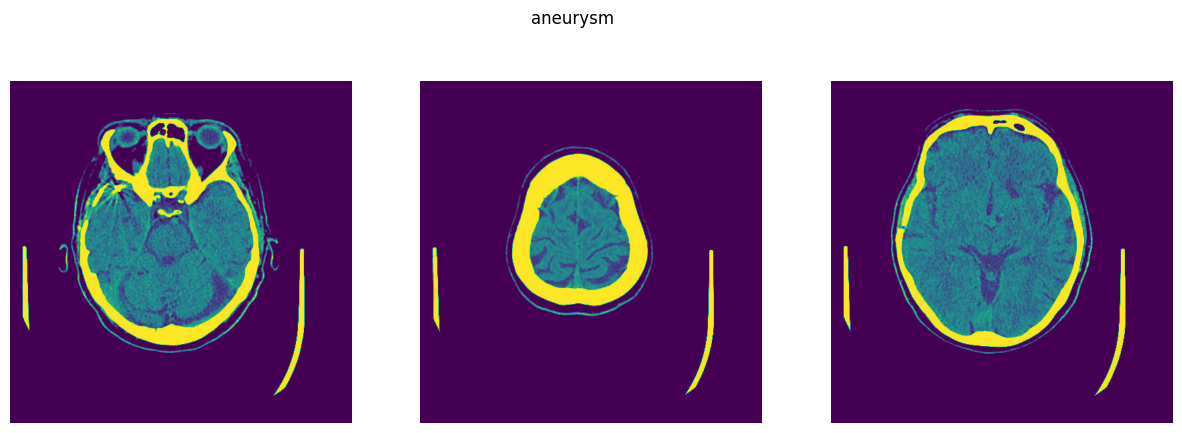

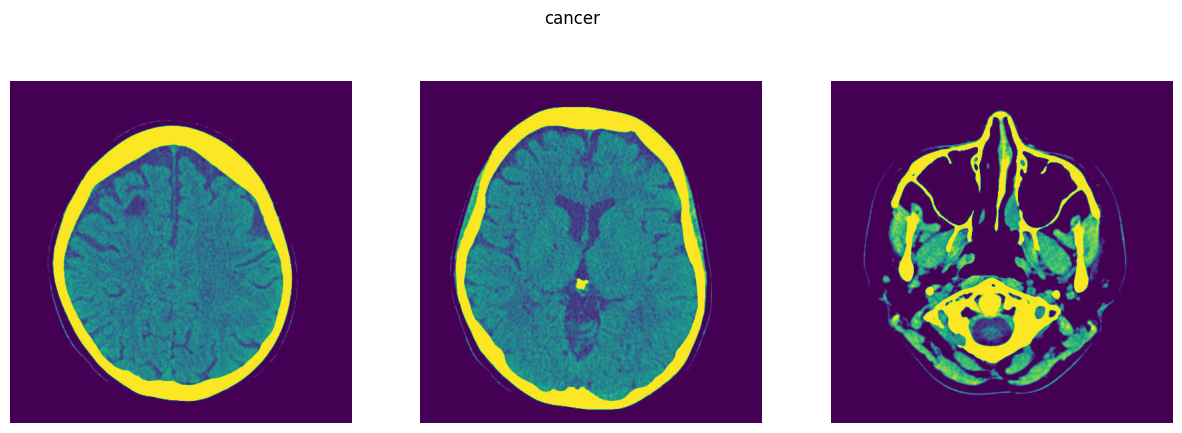

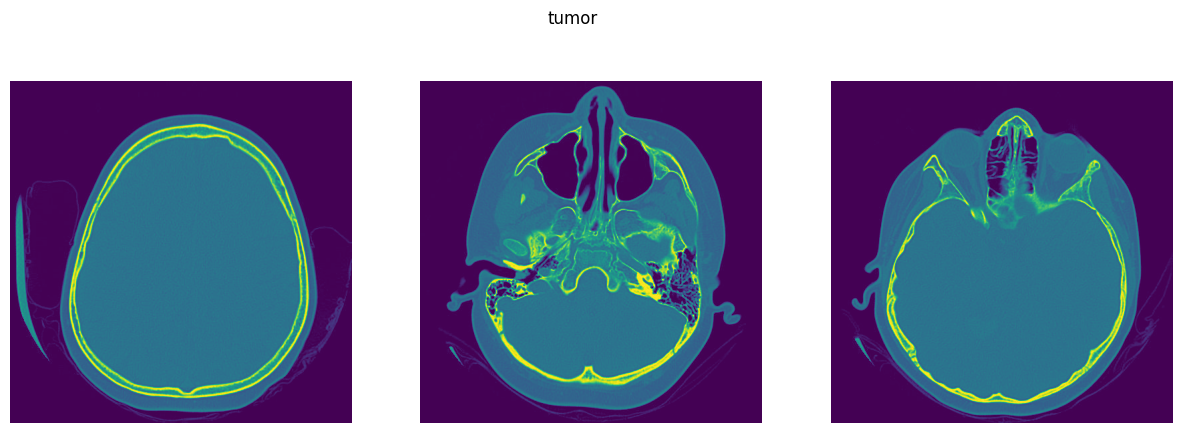

In [49]:
# Visualizacion de los datos
import plotly.express as px
import matplotlib.pyplot as plt
import cv2


unique_classes = np.unique(y_train)
class_indices = {class_id: np.where(y_train == class_id)[0] for class_id in unique_classes}
class_indices


images_count = [len(class_indices[key]) for key in class_indices.keys()]

fig = px.bar(x=class_folder_names, y=images_count, color= class_folder_names)

fig.update_layout(xaxis_title='Disease', yaxis_title='Count', title="Total samples for each class", )
fig.update_traces(texttemplate='%{y}', textposition='inside')

fig.show()

plt.figure(figsize=(12, 5))

for i, (class_id, indices) in enumerate(class_indices.items()):
    random_index = np.random.choice(indices)
    random_image = X_train[random_index] 

    plt.subplot(1, len(unique_classes), i + 1)
    plt.imshow(random_image)
    plt.title(class_folder_names[class_id])
    plt.axis('off')

plt.show()

# Define the base directory
base_dir = "archive/files/"

# Get the class folder names
class_folder_names = os.listdir(base_dir)

# Define the number of images to display for each class
images_to_display = 3

# Loop through each class
for class_id, cls in enumerate(class_folder_names):
    class_path = os.path.join(base_dir, cls)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Get a list of image files
        image_files = [file for file in os.listdir(class_path) if file.endswith('.jpg')]

        # Randomly select 'images_to_display' number of images
        selected_images = np.random.choice(image_files, images_to_display, replace=False)

        # Display the selected images for this class
        plt.figure(figsize=(15, 5))
        plt.suptitle(cls)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = img / 255.0  # Normalize to the range [0, 1]

            plt.subplot(1, images_to_display, i + 1)
            plt.imshow(img)  # Use gray colormap
            plt.axis('off')

        plt.show()



Hemos utilizado la libreria plotly para representar la cantidad de muestras de aneurisma, cancer y tumor en formato grafico de barras. Luego vemos unas muestras de las distintas imagenes.

Adicionalmente usamos libreria cv2 para ver las imagenes del cerebro en formato escaner.

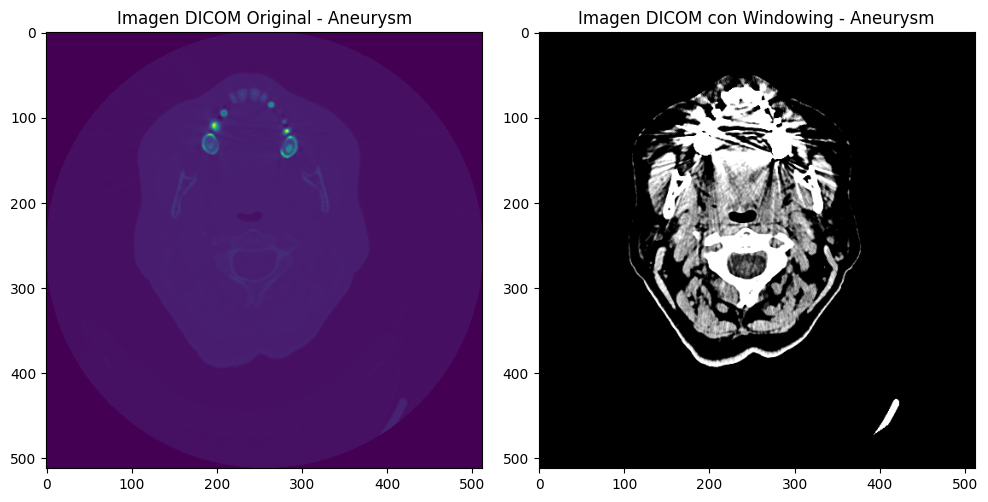

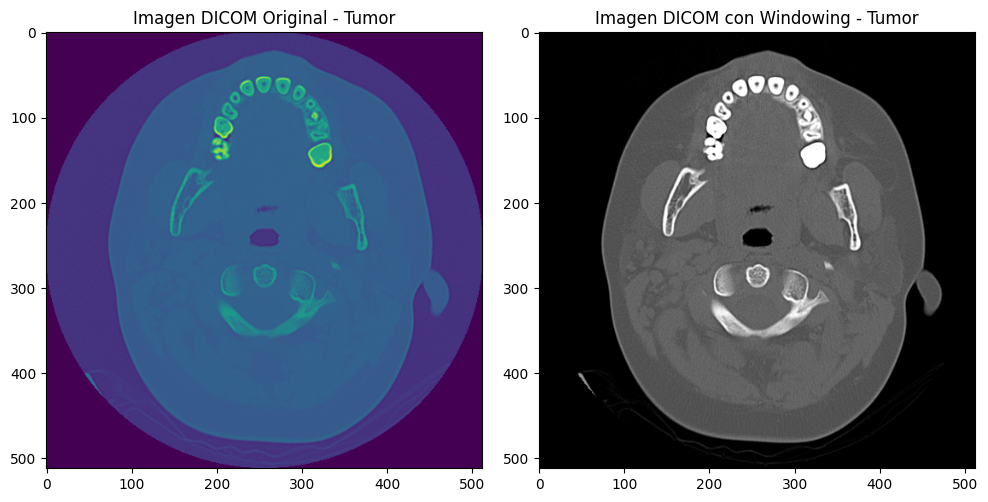

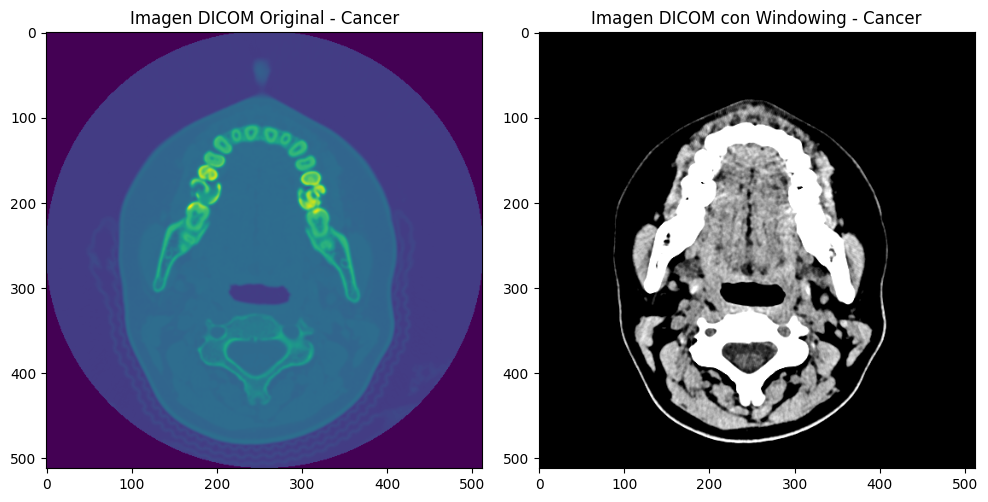

In [43]:
import matplotlib.pyplot as plt
import pydicom as dicom
import os

def load_and_display_images(disease_folder, title):
    # Obtener la lista de archivos en el directorio de la enfermedad
    files = os.listdir(disease_folder)
    
    # Filtrar archivos para obtener imágenes DICOM
    dcm_files = [file for file in files if file.lower().endswith(".dcm")]

    # Cargar la primera imagen DICOM
    dcm_path = os.path.join(disease_folder, dcm_files[0])
    dcm_dataset = dicom.dcmread(dcm_path)

    # Obtener la imagen y aplicar windowing
    dcm_image = dcm_dataset.pixel_array
    window_center = dcm_dataset.WindowCenter if hasattr(dcm_dataset, 'WindowCenter') else dcm_image.mean()
    window_width = dcm_dataset.WindowWidth if hasattr(dcm_dataset, 'WindowWidth') else dcm_image.max() - dcm_image.min()
    img_min = window_center - window_width / 2
    img_max = window_center + window_width / 2
    dcm_image = np.clip(dcm_image, img_min, img_max)

    # Crear subgráficos
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Mostrar la imagen original en el primer subgráfico
    axs[0].imshow(dcm_dataset.pixel_array)
    axs[0].set_title(f'Imagen DICOM Original - {title}')

    # Mostrar la imagen con windowing en el segundo subgráfico
    axs[1].imshow(dcm_image, cmap='gray')
    axs[1].set_title(f'Imagen DICOM con Windowing - {title}')

    # Ajustar el diseño y mostrar la figura
    plt.tight_layout()
    plt.show()

# Directorios para cada enfermedad
aneurysm_folder = "archive/files/aneurysm"
tumor_folder = "archive/files/tumor"
cancer_folder = "archive/files/cancer"

# Visualizar imágenes para cada enfermedad
load_and_display_images(aneurysm_folder, "Aneurysm")
load_and_display_images(tumor_folder, "Tumor")
load_and_display_images(cancer_folder, "Cancer")

Se ha utilizado la ibreria pydicom que se utuliza para visualizar imágenes de cerebro en formato DICOM.

El "windowing", es una técnica utilizada para ajustar la apariencia visual de las imágenes radiológicas.

Permite resaltar o mejorar la visibilidad de ciertas estructuras anatómicas o patológicas al ajustar la presentación de niveles de gris en la imagen.

### 4. Creamos el modelo de entrenamiento <span style="color:red">Falta modificar</span>


Found 259 files belonging to 3 classes.

Original Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Augmented Images:
Normalized Images:


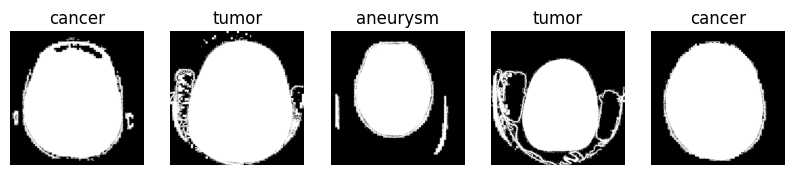

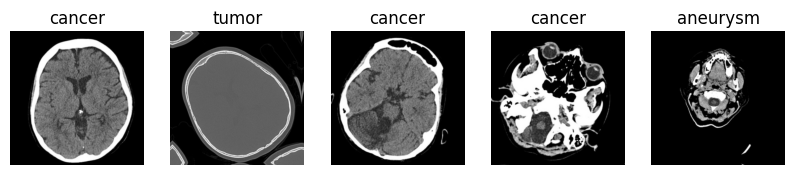

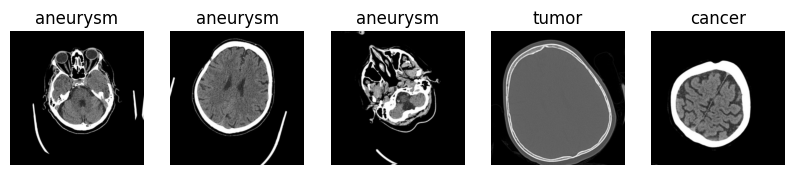

In [55]:
#####################
# CREACION DEL MODELO
#####################

# Constantes
IMAGE_SIZE = 516
BATCH_SIZE = 32

# Cargamos un batch del dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "archive/files",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Obtenemos los nombres de las clases
class_names = dataset.class_names

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Aplicamos el data augmentation rescalando la imagen
augmented_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_dataset = augmented_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Normalizmaos las imagenes y realizmaos el reescalado
normalized_dataset = augmented_dataset.map(lambda x, y: (x, y))
normalized_dataset = normalized_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Funcion para mostrar las imagenes del dataset
def show_images(dataset, num_batches=1, num_images=5):
    plt.figure(figsize=(10 * num_batches, 10 * num_images))
    for batch_num, (images, labels) in enumerate(dataset.take(num_batches)):
        for i in range(num_images):
            ax = plt.subplot(num_batches, num_images, batch_num * num_images + i + 1)
            plt.imshow(images[i].numpy().astype("float32"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Mostramos las imagenes original
print("Original Images:")
show_images(dataset)

# Mostrar las imagenes aumentadas
print("Augmented Images:")
show_images(augmented_dataset)

# Mostrar las imagenes normalizadas
print("Normalized Images:")
show_images(normalized_dataset)

plt.show()

Se utiliza prefetch para mejorar el rendimiento del conjunto de datos, permitiendo que las imágenes se carguen en paralelo mientras se entrena el modelo.

In [57]:
# Copia las clases obtenidas del conjunto de datos
class_names = class_names

def split_train_test_val(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=False):
    # Obtén el tamaño total del conjunto de datos
    ds_size = len(ds)

    # Calcula el tamaño de los conjuntos de entrenamiento, prueba y validación
    train_size = round(train_split * ds_size)
    test_size = round(test_split * ds_size)
    val_size = round(val_split * ds_size)

    # Si se solicita, baraja el conjunto de datos
    if shuffle:
        ds = ds.shuffle()

    # Divide el conjunto de datos en conjuntos de entrenamiento, prueba y validación
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)

    return train_ds, test_ds, val_ds

# Llama a la función para obtener los conjuntos de entrenamiento, prueba y validación
train_ds, test_ds, val_ds = split_train_test_val(ds=dataset)


In [58]:
tarin_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names = dataset.class_names


from tensorflow.keras import models,layers

image_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE,
    interpolation='bilinear',
    crop_to_aspect_ratio=False),
    layers.Rescaling(1./255),
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.2),
])

BATCH = 32
CHANNELS = 3

input_size = (BATCH,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    image_preprocessing,
    layers.Conv2D(32,(8,8),activation='relu',input_shape=input_size),
    layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
    layers.Conv2D(64,kernel_size=(4,4),activation='relu'),
    layers.Dropout(.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names),activation='softmax')
])

model.build(input_shape=input_size)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 516, 516, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 509, 509, 32)        6176      
                                                                 
 max_pooling2d (MaxPooling2  (32, 254, 254, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 251, 251, 64)        32832     
                                                                 
 dropout (Dropout)           (32, 251, 251, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (32, 249, 249, 64)        36928     
                                                     

In [62]:
# Aplicar un modelo o varios y entrenarlos para ver quien se comporta mejor
# a nuestra clasificacion de enfermedad cerebral 

<span style="color:red">Dentro del apartado del entrenamiento de modelo falta entrenarlo, y modificar para plantear cualquier tipo de modelo (el que mejor se ajuste o mostrar varios, etc.)</span>


### 5. Metrica <span style="color:red"> PENDIENTE</span>


In [60]:
# Mostrar las graficas y matriz de confusion


### 6. Probando el modelo <span style="color:red"> PENDIENTE</span>

In [61]:
# Probar que el modelo es capaz de predecir las imagenes

### 7. Guardamos el modelo generado

In [59]:
model.save("model_cnn_ct_brain.keras")